<a href="https://colab.research.google.com/github/Agoston03/Deep-Learning-42/blob/main/deep_learning_42_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a homework project in "Deep Learning a gyakorlatban Python és Lua alapokon".  
The team members are:

* Gyulai Gergő László
* Horváth Ágoston
* Frink Dávid

You can read more information about our chosen homework at the link below:  
https://www.kaggle.com/competitions/isic-2024-challenge

## Download and set

In this section, we will download the necessary libraries and tools.

In [1]:
!pip install kaggle==1.5.12
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73026 sha256=5a72f4c7cafcd8e0255473a3e97054117dea4b7db71d9bfd163074ee96d5236e
  Stored in directory: /root/.cache/pip/wheels/70/0c/e6/79103212a102e78b8453691b905f48000219574ba7137e7207
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


Configure Kaggle to access the API. You need to copy your own kaggle.json file into Colab in order to validate yourself

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Here, we are downloading the necessary data as a zipped file.

In [3]:
!kaggle competitions download -c isic-2024-challenge

 99% 1.98G/2.00G [00:21<00:00, 285MB/s]
100% 2.00G/2.00G [00:21<00:00, 101MB/s]



Unpacking the data while skipping the images. This may take a few minutes.

In [4]:
!unzip isic-2024-challenge.zip -x "train-image/image/*"

Archive:  isic-2024-challenge.zip
  inflating: sample_submission.csv   
  inflating: test-image.hdf5         
  inflating: test-metadata.csv       
  inflating: train-image.hdf5        
  inflating: train-metadata.csv      


Importing the necessary libraries.

In [5]:
import pandas as pd
import numpy as np
from PIL import Image
import io
import h5py
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import itertools
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

These are global variables used throughout the project.

In [6]:
NUMBER_OF_AUGMENTATIONS = 3
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

## Preparing train, test and valid set

In this section we will create the required datasets for further fitting.


Gather information about the dataset using the metadata. This code loads the metadata into a pandas DataFrame. Quite useful for extracting the IDs.

In [7]:
metadata = pd.read_csv('train-metadata.csv')
metadata.head(2)

<ipython-input-7-dc228b6d879c>:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('train-metadata.csv')


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455


Check the count of benign and malignant data.

In [8]:
benign_samples = metadata[metadata['target'] == 0]
malignant_samples = metadata[metadata['target'] == 1]

print(f'Benign images: {len(benign_samples)}')
print(f'Malignant images: {len(malignant_samples)}')

Benign images: 400666
Malignant images: 393


Here are a few sample IDs.

In [9]:
benign_ids = benign_samples['isic_id'].tolist()
malignant_ids = malignant_samples['isic_id'].tolist()

print(f'A few benign images ids: {benign_ids[:5]} ...')
print(f'A few malignant images ids: {malignant_ids[:5]} ...')

A few benign images ids: ['ISIC_0015670', 'ISIC_0015845', 'ISIC_0015864', 'ISIC_0015902', 'ISIC_0024200'] ...
A few malignant images ids: ['ISIC_0082829', 'ISIC_0096034', 'ISIC_0104229', 'ISIC_0119495', 'ISIC_0157834'] ...


This function helps visualize the distribution of the generated datasets.

In [10]:
def visualize_dataset_split(train_benign_ids, train_malignant_ids,
                             valid_benign_ids, valid_malignant_ids,
                             test_benign_ids, test_malignant_ids):

  benign_counts = [len(train_benign_ids), len(valid_benign_ids), len(test_benign_ids)]
  malignant_counts = [len(train_malignant_ids), len(valid_malignant_ids), len(test_malignant_ids)]

  labels = ['Train', 'Validation', 'Test']
  width = 0.35

  x = np.arange(len(labels))

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, benign_counts, width, label='Benign', color='#6890F0')
  rects2 = ax.bar(x + width/2, malignant_counts, width, label='Malignant', color='#fdaa48')

  ax.set_ylabel('Number of Samples')
  ax.set_title('Dataset Split Distribution')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  plt.show()

In this section, we will prepare the datasets for the subsequent fitting processes. The training dataset contains a limited number of samples to maintain the desired balance. Unfortunately, there is a smaller fraction of benign samples due to the scarcity of malignant samples.

In [11]:
train_malignant_count = 300
test_malignant_count = 50
valid_malignant_count = 43

train_benign_count = train_malignant_count * (NUMBER_OF_AUGMENTATIONS + 1)
test_benign_count = test_malignant_count * (NUMBER_OF_AUGMENTATIONS + 1)
valid_benign_count = valid_malignant_count * (NUMBER_OF_AUGMENTATIONS + 1)

train_malignant_ids = malignant_ids[:train_malignant_count]
test_malignant_ids = malignant_ids[train_malignant_count:train_malignant_count + test_malignant_count]
valid_malignant_ids = malignant_ids[train_malignant_count + test_malignant_count:train_malignant_count + test_malignant_count + valid_malignant_count]

train_benign_ids = benign_ids[:train_benign_count]
test_benign_ids = benign_ids[train_benign_count:train_benign_count + test_benign_count]
valid_benign_ids = benign_ids[train_benign_count + test_benign_count:train_benign_count + test_benign_count + valid_benign_count]

It is a bar chart showing the distribution of the previously created dataset.

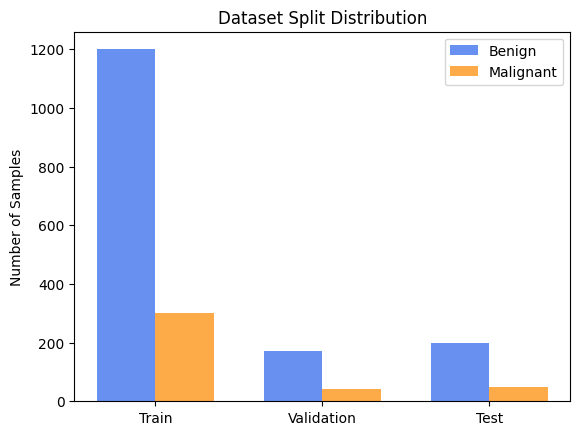

In [12]:
visualize_dataset_split(train_benign_ids,
                        train_malignant_ids,
                        valid_benign_ids,
                        valid_malignant_ids,
                        test_benign_ids,
                        test_malignant_ids)

We will first train an autoencoder model on large amounts of image data to get a model, that has deep knowledge about the skin sufaces and leisures.

Here we create the datasets for that purpose

In [13]:
autoencoder_train_benign_count = 100000
autoencoder_train_malignant_count = 300

autoencoder_valid_benign_count = 100
autoencoder_valid_malignant_count = 10

autoencoder_train_benign_ids = benign_ids[:autoencoder_train_benign_count]
autoencoder_train_malignant_ids = malignant_ids[:autoencoder_train_malignant_count]

autoencoder_valid_benign_ids = benign_ids[autoencoder_train_benign_count:autoencoder_train_benign_count + autoencoder_valid_benign_count]
autoencoder_valid_malignant_ids = malignant_ids[autoencoder_train_malignant_count:autoencoder_train_malignant_count + autoencoder_valid_malignant_count]


This is a bar chart showing the distribution of the previously created dataset.

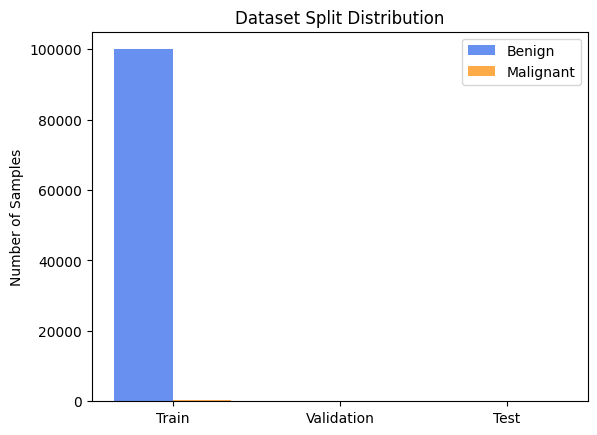

In [14]:
visualize_dataset_split(autoencoder_train_benign_ids,
                        autoencoder_train_malignant_ids,
                        autoencoder_valid_benign_ids,
                        autoencoder_valid_malignant_ids,
                        [],
                        [])

## Visualizing the images

This section focuses on loading and visualizing a few images.

This function loads a certain number of sample images.


In [15]:
def load_images_and_labels(h5_file_path, benign_ids, malignant_ids, num_images=5):
    images = []
    labels = []

    image_ids = benign_ids + malignant_ids
    image_ids = image_ids[:num_images]

    with h5py.File(h5_file_path, 'r') as f:
        for img_key in image_ids:
            image_data = f[img_key][()]
            image = np.array(Image.open(io.BytesIO(image_data)).resize((224, 224)))
            images.append(image)
            labels.append(0 if img_key in benign_ids else 1)

    return np.array(images), np.array(labels), image_ids

Visualizing a sample of the data we have.

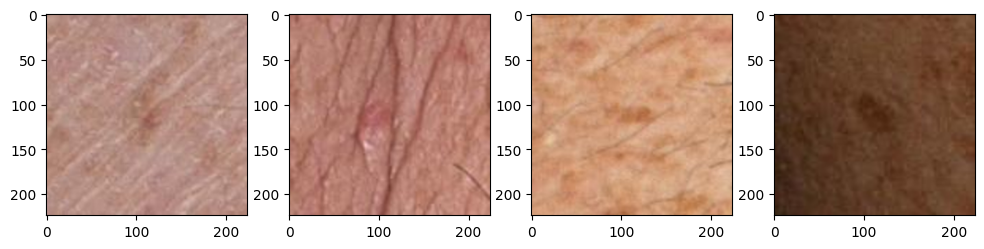

In [16]:
images, labels, image_ids = load_images_and_labels('train-image.hdf5', train_benign_ids, train_malignant_ids, num_images=4)
nrows, ncols = 4, 4

fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

for i, image in enumerate(images):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(image)

plt.show()

## Defining and trainging the model

In this section, we define our **model** for detection.

We **train** the model in the following way:
1. We create an **autoencoder** and train it on a buch of our benign data
2. We use the **encoder** part of the **autoencoder** as a base for our classification task
3. We add fully connected layers to the encoder and train it to differentiate the two classes: **benign** and **malignant**

This function provides a straightforward way to create an instance of an ImageDataGenerator. Simplifying the initialization of this part by defining a function for it.

In [17]:
def image_generator_factory():
  return ImageDataGenerator(
      rescale=1./255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      rotation_range=30,
      brightness_range=[0.8, 1.2],
  )


It is a helper function for loading images.

In [18]:
def load_and_preprocess_image(image_data):
    image = Image.open(io.BytesIO(image_data))
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))
    return np.array(image)

It's a helper function for the various data generator functions. It yields rescaled and augmented images concatenated with their labels.

In [19]:
def next_data_generator(benign_ids, malignant_ids, augment, image_generator):
  ids = benign_ids + malignant_ids
  id_cycle = itertools.cycle(ids)

  while True:
      with h5py.File('train-image.hdf5', 'r') as f:
          img_id = next(id_cycle)
          image = load_and_preprocess_image(f[img_id][()])
          label = 1 if img_id in malignant_ids else 0
          yield image / 255.0, label

          if label == 1 and augment:
              for _ in range(NUMBER_OF_AUGMENTATIONS):
                  yield image_generator.random_transform(image), label

This function generates images represented as NumPy arrays along with their labels. I added the 'augment' parameter, which allows us to specify whether advanced augmentation is needed in addition to rescaling.

In [20]:
def data_generator(benign_ids, malignant_ids, image_generator, augment, batch_size=32):
  get_next = next_data_generator(benign_ids, malignant_ids, augment, image_generator)

  while True:
      batch_data, batch_labels = zip(*(
          next(get_next) for _ in range(batch_size)
      ))

      yield np.array(batch_data), np.array(batch_labels)

This function is for the autoencoder training.

In [21]:
def autoencoder_data_generator(benign_ids, malignant_ids, image_generator, batch_size=32):
  get_next = next_data_generator(benign_ids, malignant_ids, False, image_generator)

  while True:
      batch_data, _ = zip(*(
          next(get_next) for _ in range(batch_size)
      ))

      yield np.array(batch_data), np.array(batch_data)

Here I define the autoencoder model.

In [22]:
def build_autoencoder(input_shape=(128, 128, 3)):
  input_img = Input(shape=input_shape)

  x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)

  x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = UpSampling2D((2, 2))(x)
  decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

  encoder = Model(input_img, encoded)

  autoencoder = Model(input_img, decoded)

  autoencoder.compile(
      optimizer='adam',
      loss='mean_squared_error',
      metrics=['mse']
  )

  return autoencoder, encoder

This block of code train the autoencoder.

In [ ]:
image_generator = image_generator_factory()

train_generator = autoencoder_data_generator(autoencoder_train_benign_ids, autoencoder_train_malignant_ids, image_generator, BATCH_SIZE)
validation_generator = autoencoder_data_generator(autoencoder_valid_benign_ids, autoencoder_valid_malignant_ids, image_generator, BATCH_SIZE)

steps_per_epoch = (autoencoder_train_benign_count + autoencoder_train_malignant_count) // BATCH_SIZE
validation_steps = (autoencoder_valid_benign_count + autoencoder_valid_malignant_count) // BATCH_SIZE

autoencoder, encoder = build_autoencoder((IMG_WIDTH, IMG_HEIGHT, 3))

autoencoder.fit(
  train_generator,
  validation_data=validation_generator,
  steps_per_epoch=steps_per_epoch,
  validation_steps=validation_steps,
  epochs=10,
  verbose=2
)

Epoch 1/10
19/19 - 13s - 659ms/step - accuracy: 0.9510 - loss: 0.0192 - precision: 0.9975 - recall: 0.7007 - val_accuracy: 0.9931 - val_loss: 0.0192 - val_precision: 0.9977 - val_recall: 0.3348
Epoch 2/10
19/19 - 1s - 59ms/step - accuracy: 0.9994 - loss: 0.0174 - precision: 0.9976 - recall: 0.5430 - val_accuracy: 0.9992 - val_loss: 0.0181 - val_precision: 0.9986 - val_recall: 0.6628
Epoch 3/10
19/19 - 1s - 61ms/step - accuracy: 0.9993 - loss: 0.0157 - precision: 0.9982 - recall: 0.6606 - val_accuracy: 0.9930 - val_loss: 0.0166 - val_precision: 0.9988 - val_recall: 0.6377
Epoch 4/10
19/19 - 1s - 59ms/step - accuracy: 0.9994 - loss: 0.0131 - precision: 0.9983 - recall: 0.5993 - val_accuracy: 0.9937 - val_loss: 0.0104 - val_precision: 1.0000 - val_recall: 0.5768
Epoch 5/10
19/19 - 1s - 61ms/step - accuracy: 0.9994 - loss: 0.0056 - precision: 0.9995 - recall: 0.5857 - val_accuracy: 0.9931 - val_loss: 0.0038 - val_precision: 0.9999 - val_recall: 0.4745
Epoch 6/10
19/19 - 1s - 59ms/step - ac

Visualizing the Autoencoder's Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


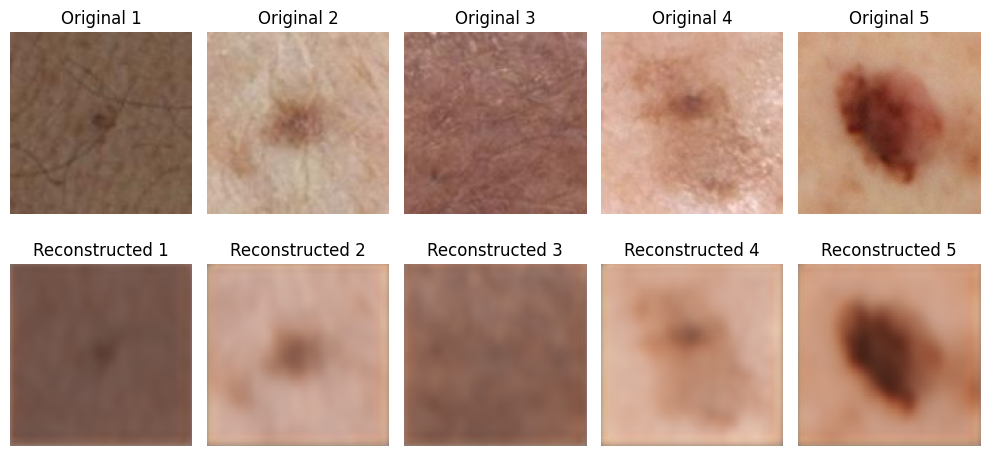

In [ ]:
def reconstruct_images(autoencoder, images):
    reconstructed_images = autoencoder.predict(images)
    return reconstructed_images

num_images_to_visualize = 5
validation_images, _ = next(validation_generator)
validation_images = validation_images[:num_images_to_visualize]

reconstructed_images = reconstruct_images(autoencoder, validation_images)

plt.figure(figsize=(10, 5))
for i in range(num_images_to_visualize):
    plt.subplot(2, num_images_to_visualize, i + 1)
    plt.imshow(validation_images[i])
    plt.title(f"Original {i+1}")
    plt.axis('off')

    plt.subplot(2, num_images_to_visualize, i + 1 + num_images_to_visualize)
    plt.imshow(reconstructed_images[i])
    plt.title(f"Reconstructed {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Build the model with hyperparameters

In [ ]:
def build_model(hp):
    x = encoder.output
    x = layers.Flatten()(x)
    activation = hp.Choice('activation', values=['relu', 'tanh'])
    x = Dense(hp.Int('dense_units', 128, 512, step=128), activation=activation)(x)
    x = Dropout(hp.Float('dropout', 0.1, 0.5, step=0.2))(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=encoder.input, outputs=output)

    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision']
    )

    return model

In [ ]:
tuner = keras_tuner.Hyperband(
  build_model,
  objective='val_accuracy',
  max_epochs=20,
  factor=3,
  directory='output',
  project_name='DP42_with_hp'
)

Start tuner on the built model

In [ ]:
train_generator = data_generator(train_benign_ids, train_malignant_ids, image_generator, BATCH_SIZE)
validation_generator = data_generator(valid_benign_ids, valid_malignant_ids, image_generator, BATCH_SIZE)

steps_per_epoch = (len(train_benign_ids) + len(train_malignant_ids) * (NUMBER_OF_AUGMENTATIONS + 1)) // BATCH_SIZE
validation_steps = (len(valid_benign_ids) + len(valid_malignant_ids) * (NUMBER_OF_AUGMENTATIONS + 1)) // BATCH_SIZE

tuner.search(train_generator,
             validation_data=validation_generator,
             epochs=10,
             steps_per_epoch= steps_per_epoch,
             validation_steps=validation_steps)

Create callbacks for the fine tuning of the best model

In [ ]:
callbacks = [
  EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max'),
  ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, min_lr=1e-6, mode='max'),
  ModelCheckpoint(filepath='best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
]

Fine tune the current best model

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

hist = best_model.fit(
  train_generator,
  validation_data=validation_generator,
  steps_per_epoch=steps_per_epoch,
  validation_steps=validation_steps,
  epochs=50,
  verbose=2,
  callbacks=callbacks
)

This function creates a confusion matrix for visualization.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

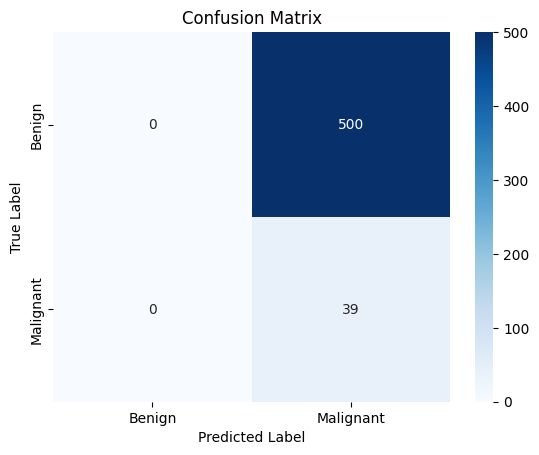

In [ ]:
def evaluate_and_visualize(model, test_benign_ids, test_malignant_ids):
    y_true = []
    y_pred = []

    with h5py.File('train-image.hdf5', 'r') as f:
        for img_id in test_benign_ids + test_malignant_ids:
            image = load_and_preprocess_image(f[img_id][()])
            image = image / 255.0
            image = np.expand_dims(image, axis=0)
            label = 1 if img_id in test_malignant_ids else 0
            prediction = model.predict(image)
            y_true.append(label)
            y_pred.append(np.round(prediction).flatten()[0])

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return y_pred, y_true

y_pred, y_true = evaluate_and_visualize(best_model, benign_ids[2000:2500], test_malignant_ids)

Partial area under the ROC curve (pAUC) above 80% true positive rate (TPR) for binary classification of malignant examples.

The receiver operating characteristic (ROC) curve illustrates the diagnostic ability of a given binary classifier system as its discrimination threshold is varied. However, there are regions in the ROC space where the values of TPR are unacceptable in clinical practice. Systems that aid in diagnosing cancers are required to be highly-sensitive, so this metric focuses on the area under the ROC curve AND above 80% TRP. Hence, scores range from [0.0, 0.2].

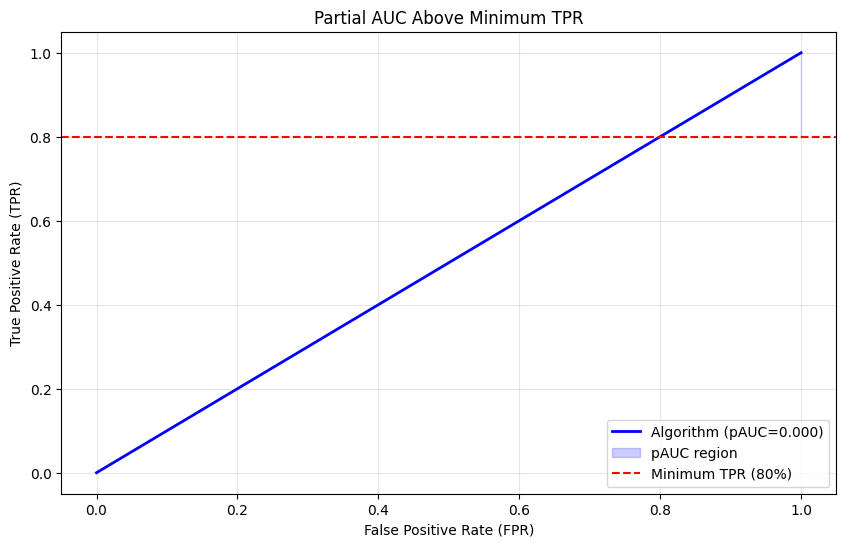

In [ ]:
def generate_pAUC_plot(algorithm_probs, true_labels, min_tpr=0.8):
  fpr_a, tpr_a, _ = roc_curve(true_labels, algorithm_probs)

  min_tpr_idx_a = np.where(tpr_a >= min_tpr)[0]

  fpr_a_high_tpr, tpr_a_high_tpr = fpr_a[min_tpr_idx_a], tpr_a[min_tpr_idx_a]

  if len(fpr_a_high_tpr) < 2:
      print("Warning: Insufficient data points to calculate pAUC. Returning 0.")
      pAUC_a = 0.0
  else:
      pAUC_a = auc(fpr_a_high_tpr, tpr_a_high_tpr)

  plt.figure(figsize=(10, 6))
  plt.plot(fpr_a, tpr_a, label=f'Algorithm (pAUC={pAUC_a:.3f})', color='blue', linewidth=2)

  if len(fpr_a_high_tpr) > 0 :
      plt.fill_between(fpr_a_high_tpr, tpr_a_high_tpr, min_tpr, color='blue', alpha=0.2, label='pAUC region')

  plt.axhline(y=min_tpr, color='red', linestyle='--', label=f'Minimum TPR ({min_tpr*100:.0f}%)')
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.title('Partial AUC Above Minimum TPR')
  plt.legend(loc='lower right')
  plt.grid(alpha=0.3)
  plt.show()

generate_pAUC_plot(y_pred, y_true)